In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [23]:
import sys
import math
import torch
import time

import pandas as pd
import numpy as np
import torch.nn as nn

from tqdm import tqdm
from torch import optim
from pathlib import Path
from docopt import docopt

from model import *
from utils import prepare_df
from language_structure import load_model, Lang

base = Path('../aclImdb')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Data
df = pd.read_csv('train.csv')
lang = load_model()

# Model
hidden_size = 20
embed_size = 300
model = SentModel(embed_size, hidden_size, lang, device)
model = model.to(device)

lr = 1e-3
clip_grad = 5.
optimizer = torch.optim.Adam(model.parameters())
loss_fcn = nn.BCELoss()

# Structure Test Data 

In [6]:
from init import extract_helper

In [7]:
neg_exs, neg_labels, neg_ratings = extract_helper('test/neg/', 0)
pos_exs, pos_labels, pos_ratings = extract_helper('test/pos/', 1)

In [54]:
test_df = pd.DataFrame(data={'path': neg_exs + pos_exs,
                        'target': neg_labels + pos_labels,
                        'review_rating': neg_ratings + pos_ratings})
test_df = test_df.sample(frac=1.)
test_df.to_csv('test.csv', index=False)

# Predictions + Accuracy 

In [1]:
from train import batch_iter

In [2]:
test_df = pd.read_csv('test.csv')

NameError: name 'pd' is not defined

In [56]:
threshold = torch.tensor([0.5])
n_examples = 0
n_correct = 0
for sents, targets in batch_iter(lang, test_df[:2000], 10, shuffle=True):
    preds = model(sents)
    preds = (preds >= threshold).float()
    n_correct += torch.eq(preds, targets).sum().float()
    n_examples += len(targets)

(tensor(8.),
 10,
 tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 0.]))

In [5]:
model(ex)

NameError: name 'ex' is not defined

In [6]:
test = torch.tensor([0.5, 0.2, 0.2])
test

tensor([0.5000, 0.2000, 0.2000])

In [7]:
t = torch.tensor([0.5])
t

tensor([0.5000])

In [8]:
preds_rounded = (test >= t).float()
preds_rounded

tensor([1., 0., 0.])

In [9]:
true = torch.tensor([1, 0, 1]).float()
true

tensor([1., 0., 1.])

In [14]:
(1 - torch.abs(preds_rounded - true)).sum() / len(true)

tensor(0.6667)

In [16]:
torch.eq(preds_rounded, true).sum().float() / len(true) 

tensor(0.6667)

In [40]:
len(true)

3

In [ ]:
def validate():
    threshold = torch.tensor([0.5])
    n_examples = 0
    n_correct = 0
    for sents, targets in batch_iter(lang, test_df[:2000], 10, shuffle=True):
        preds = model(sents)
        preds = (preds >= threshold).float()
        n_correct += (1 - torch.abs(preds - targets)).sum()
        n_examples += len(targets)
    
    return n_correct / n_examples

In [17]:
loss = accuracy = val_loss = val_accuracy = []

In [18]:
loss.append(1)

In [19]:
loss, accuracy, val_loss, val_accuracy 

([1], [1], [1], [1])

In [20]:
loss = accuracy = val_loss = val_accuracy = 0

In [21]:
loss += 1

In [22]:
loss, accuracy, val_loss, val_accuracy 

(1, 0, 0, 0)

# Metrics

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
model_save_path = 'model.bin'

In [2]:
# metrics = torch.load('metric_saves/' + model_save_path + '.metrics')

def plot_metrics(metrics):
    print("Total Time: {} \nTrain Time: {}".format(metrics['total_time'], metrics['train_time']))
    metrics = pd.DataFrame(metrics)
    metrics['itr'] = list(range(len(metrics['train_loss'])))
    metrics['val_itr'] = list(range(len(metrics['val_loss'])))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    
    # plot loss 
    ax1.plot(metrics['itr'], metrics['train_loss'])
    ax1.plot(metrics['val_itr'], metrics['val_loss'])
    ax1.legend()
    ax1.set_xlabel('Training Iteration')
    ax1.set_ylabel('Loss')
    ax1.set_title('Model Loss')
    
    # plot accuracy
    ax2.plot(metrics['itr'], metrics['train_acc'])
    ax2.plot(metrics['val_itr'], metrics['val_acc'])
    ax2.legend()
    ax2.set_xlabel('Training Iteration')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Model Accuracy')
    
    plt.plot()

plot_metrics(metrics)

NameError: name 'metrics' is not defined

# Testing Types of Tokenization

In [1]:
from bert.tokenization import WordpieceTokenizer, FullTokenizer
import os

In [50]:
vocab_file = 'vocab.txt'
with open(vocab_file, 'r') as f:
    vocab_tokens = f.read().split('\n')

vocab = {}
for (i, token) in enumerate(vocab_tokens):
    vocab[token] = i

In [56]:
tokenizer = FullTokenizer(vocab_file, do_lower_case=True)

In [59]:
tokenizer.tokenize(' '.join(["John", "Johanson", "'s",  "house"]))

['john', 'johan', '##son', "'", 's', 'house']

In [60]:
tokenizer.tokenize("unwanted running")

['unwanted', 'running']

Tokenizer 2 below...

In [17]:
vocab_tokens = [
    "[UNK]", "[CLS]", "[SEP]", "want", "##want", "##ed", "wa", "un", "runn", "##ing"
]

vocab = {}
for (i, token) in enumerate(vocab_tokens):
    vocab[token] = i

In [32]:
tokenizer = WordpieceTokenizer(vocab)
tokenizer.tokenize("unwanted running")

['un', '##want', '##ed', 'runn', '##ing']

In [62]:
wordlist = ['construct','destructer','constructs','deconstructs']

from pyparsing import StringEnd, oneOf, FollowedBy, Optional, ZeroOrMore, SkipTo

endOfString = StringEnd()
prefix = oneOf("de con")
suffix = oneOf("er s") + FollowedBy(endOfString)

word = (ZeroOrMore(prefix)("prefixes") + 
        SkipTo(suffix | endOfString)("root") + 
        Optional(suffix)("suffix"))

for wd in wordlist[:1]:
    print(wd)
    res = word.parseString(wd)
    print(res.dump())
    print(res.prefixes)
    print(res.root)
    print(res.suffix)

construct
['con', 'struct']
- prefixes: ['con']
- root: 'struct'
['con']
struct



In [2]:
import spacy

In [3]:
token = 'unwanted'
n = 2
ngram_word = [token[i:i+n] for i in range(len(token))]
ngram_word

['un', 'nw', 'wa', 'an', 'nt', 'te', 'ed', 'd']

In [6]:
nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)

In [7]:
text = nlp("My system keeps crashing! his crashed yesterday, ours crashes daily")
text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
text

'My system keep crash ! his crashed yesterday , ours crash daily'

# Self Attention Model - Transformer

In [5]:
from language_structure import *

In [21]:
lang = load_model()

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [116]:
# seperate module to make attention analysis easy
class TransformerEmbedder(nn.Module):
    def __init__(self, embed_dim, num_embed, num_pos, dropout):
        super().__init__()
        self.token_embeddings = nn.Embedding(num_embed, embed_dim)
        # Lazy positional embeddings
        self.pos_embeddings = nn.Embedding(num_pos, embed_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, lang, device):
        x, _ = to_input_tensor(lang, x, device)
        positions = torch.arange(len(x), device=x.device).unsqueeze(-1)
        h = self.token_embeddings(x)
        h = h + self.pos_embeddings(positions).expand_as(h)
        h = self.dropout(h)
        
        return h, len(x)

In [117]:
# Thanks to, 
# https://twitter.com/Thom_Wolf/status/1129658539142766592
# AND using the Transformer as Classifier Thanks To, 
# https://www.aclweb.org/anthology/W18-5429
class TransformerClassifier(nn.Module):
    def __init__(self, lang, device, embed_dim, hidden_dim, num_embed, num_pos, num_heads, num_layers, dropout, n_classes):
        super().__init__()
        self.device = device
        self.lang = lang
        
        self.encoder = TransformerEmbedder(embed_dim, num_embed, num_pos, dropout)
        self.dropout = nn.Dropout(dropout)
        
        self.attentions, self.feed_forwards = nn.ModuleList(), nn.ModuleList()
        self.ln_1, self.ln_2 = nn.ModuleList(), nn.ModuleList()
        for _ in range(num_layers):
            self.attentions.append(nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout))
            self.feed_forwards.append(nn.Sequential(nn.Linear(embed_dim, hidden_dim),
                                                    nn.ReLU(), 
                                                    nn.Linear(hidden_dim, embed_dim)))
            self.ln_1.append(nn.LayerNorm(embed_dim, eps=1e-12))
            self.ln_2.append(nn.LayerNorm(embed_dim, eps=1e-12))
        
        self.classify = nn.Linear(embed_dim, n_classes)
        
        # init weights 
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
                                      
    def forward(self, x):
        h, x_len = self.encoder(x, self.lang, self.device)
        
        # Create masks for attention to only look left 
        attn_mask = torch.full((x_len, x_len), -float('Inf'), device=h.device, dtype=h.dtype)
        attn_mask = torch.triu(attn_mask, diagonal=1)
        
        # Through the layers we go
        for layer_norm1, attention, layer_norm2, feed_forward in zip(self.ln_1, self.attentions,
                                                                     self.ln_2, self.feed_forwards):
            h = layer_norm1(h)
            x, w = attention(h, h, h, attn_mask=attn_mask)
            x = self.dropout(x)
            h = x + h 
            
            h = layer_norm2(h)
            x = feed_forward(h)
            x = self.dropout(x)
            h = x + h
            
        # bs, sent_len, embed_dim
        h = h.transpose(0, 1)
        x, _ = torch.max(h, 1)
        y = F.softmax(self.classify(x), dim=-1).squeeze(-1)
        
        return y

In [118]:
num_max_pos = 1000
num_embed = lang.n_words
model = TransformerClassifier(lang, device, embed_dim=20, hidden_dim=20, num_embed=num_embed, num_pos=num_max_pos, 
                    num_heads=10, num_layers=3, dropout=0.3, n_classes=1)

In [21]:
from train import batch_iter
from model import TransformerClassifier

In [13]:
train_df = pd.read_csv('train.csv')

In [185]:
for sents, targets in batch_iter(lang, train_df, 3, shuffle=True):
    x = sents
    break

In [70]:
from utils import to_input_tensor

In [187]:
ex, lengths = to_input_tensor(lang, x, device)
ex.shape

torch.Size([145, 3])

In [119]:
model(x)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       grad_fn=<SqueezeBackward1>)

In [93]:
lengths

[639, 128]

In [144]:
def clip_sents(sents):
    min_seq = min(map(len, sents))
    def clip(s):
        if len(s) > min_seq:
            s = s[:min_seq]
        return s
    sents_clipped = [clip(s) for s in sents]
    return sents_clipped

In [145]:
for i in clip_sents(ex):
    print(len(i))

137
137
137


In [88]:
nn.Embedding(lang.n_words, 10)(x).shape

torch.Size([639, 2, 10])

In [89]:
model(ex).shape

torch.Size([639, 2, 20])
torch.Size([639, 2, 20])
torch.Size([639, 2, 20])
torch.Size([2, 639, 20])
torch.Size([2, 20])


torch.Size([2])

In [32]:
# def transformer_attention(model, x, lang, device):
#     y = list(model.children())[0](x, lang, device)
#     v, w = list(model.children())[2][0](y, y, y)
#     return w

# Plotting Attention

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [206]:
w = tracked_attention_weigths[0]
w.detach().numpy().squeeze().shape

(3, 145, 145)

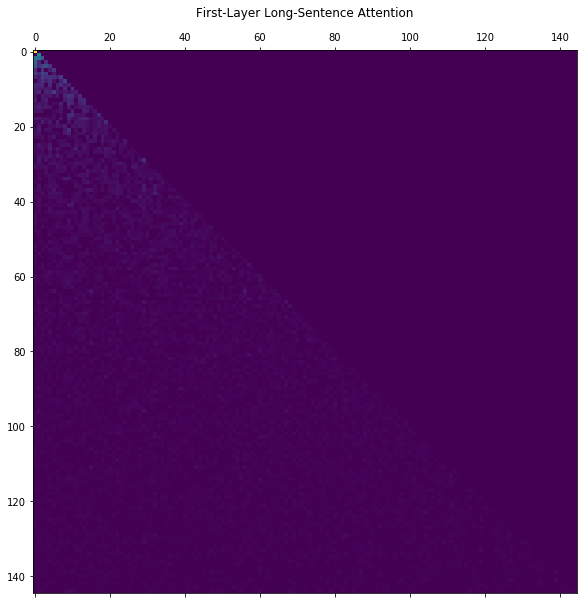

many of the american people would say . . . what ? ? ? to my opening comment . yes i know that my comparison is without doubts an insult for the fans of the master akira kurosawa but if you analyze this movie my comment is right . we have the peasant who goes to the town searching for help against a band of grasshoppers who wants to steal the harvest of the village . the great difference is the way that the story takes . our samurais a band of circus performers as in the original are a very complex mixture of personalities but at the end are what the village needs heroes . please watch again this incredible movie the seven samurai obviously and find another movies who has stolen the story and tried to get the same magic effect


In [212]:
# Thanks to, 
# https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention
batch_index = 0
sentence = x[batch_index]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
attention = w.detach().numpy().squeeze()
attention = attention[batch_index] if type(batch_index) == int else attention
ax.matshow(attention, cmap='viridis')
fontdict = {'fontsize': 14}

# ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
# ax.set_yticklabels([''] + sentence, fontdict=fontdict)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_title("First-Layer Long-Sentence Attention")

plt.show()
print(' '.join(x[0]))

# Re-Structure DataFrame To Include Length 
Then train on only long-sequences of data for analysis of self-attention in length


In [146]:
train_df = pd.read_csv('train.csv')
train_df.sample(frac=1.).head()

,path,target,review_rating,file_length
13033,train/pos/2655_10.txt,1,10,750
8522,train/neg/778_2.txt,0,2,305
19669,train/pos/6739_7.txt,1,7,664
6099,train/neg/5189_2.txt,0,2,166
433,train/neg/4929_3.txt,0,3,312


In [103]:
lengths = []
for path in train_df['path'].values:
    file = open(str(base/path), encoding='utf-8').read()
    lengths.append(len(file.split(' ')))

In [105]:
train_df['file_length'] = lengths
train_df.head()

,path,target,review_rating,file_length
0,train/neg/1821_4.txt,0,4,41
1,train/neg/10402_1.txt,0,1,188
2,train/neg/1062_4.txt,0,4,122
3,train/neg/9056_1.txt,0,1,354
4,train/neg/5392_3.txt,0,3,794


In [128]:
train_df.to_csv('train.csv', index=False)

In [125]:
pd.read_csv(io.StringIO(train_df.to_csv()), index_col=0).head()

,Unnamed: 0.1,path,target,review_rating,file_length
0,0,train/neg/1821_4.txt,0,4,41
1,1,train/neg/10402_1.txt,0,1,188
2,2,train/neg/1062_4.txt,0,4,122
3,3,train/neg/9056_1.txt,0,1,354
4,4,train/neg/5392_3.txt,0,3,794


In [149]:
len(train_df[train_df.file_length > 200])

10352

In [150]:
max(train_df.file_length.values)

2470

In [127]:
from train import load
from model import *

In [80]:
w = transformer_attention(model, x, lang, device)

torch.Size([154, 3, 20])


In [121]:
model._modules.keys()

odict_keys(['encoder', 'dropout', 'attentions', 'feed_forwards', 'ln_1', 'ln_2', 'classify'])

In [193]:
model, optim, lang = load('model_saves/' + 'e=5_itr=3_cancel_model.bin')

In [202]:
attentions = model._modules.get('attentions')

tracked_attention_weigths = []
def show(m, i, o): 
    _, w = o
    tracked_attention_weigths.append(w)
    
hook = attentions[0].register_forward_hook(show)

In [204]:
h_x = model(x)
hook.remove()

In [205]:
tracked_attention_weigths[0].shape

torch.Size([3, 145, 145])